# SVM Classifier

In [62]:
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.table import Table, vstack, MaskedColumn
from astroquery.gaia import Gaia
from scipy.stats import reciprocal, uniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import os
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

### Gaia data retrieval

In [65]:
# Load fits data
loaded = Table.read("/Users/anais/Desktop/Etudes/MASS/Nice/Courses/Mchine Learning/Project/TESTINGData_150kstars_150kgalaxies_150kquasars.fits", format="fits")

# Convert all columns to MaskedColumn to handle missing values properly
for colname in loaded.colnames:
    loaded[colname] = MaskedColumn(loaded[colname])

### Features, optimisation of hyperparameters, classifier, scores and confusion matrix

Train accuracy: 0.9990333333333333
Train classification report:
               precision    recall  f1-score   support

      galaxy       1.00      1.00      1.00     10058
      quasar       1.00      1.00      1.00     10087
        star       1.00      1.00      1.00      9855

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END svc__C=9.661761457749352, svc__coef0=1, svc__degree=4, svc__gamma=0.0010994335574766201, svc__kernel=rbf; total time=   3.8s
[CV] END svc__C=5.951769101112702, svc__coef0=0, svc__degree=4, svc__gamma=0.06586289317583113, svc__kernel=sigmoid; total time=   3.0s
[CV] END svc__C=6.867511656638483, svc__coef0=0, svc__degree=2, svc__gamma=0.00191358804876923, svc__kernel=poly; total time=  27.3s
[CV] END svc__C=6.96850157946487, svc__coef0=1, svc__degree=4, svc__gamma=0.00158471012104

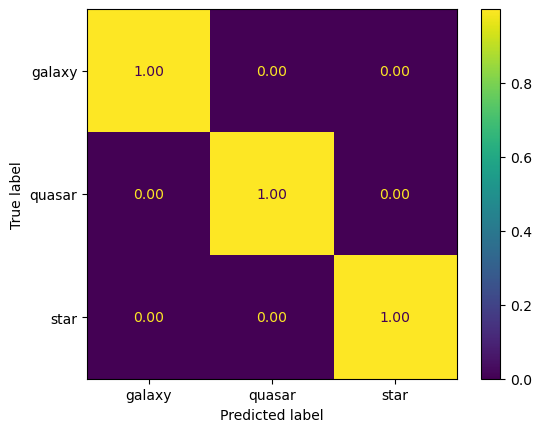

In [90]:
# Select the features to use for classification
features = [
        "sinb",                  # sine of the Galactic latitude
        "parallax",               # parallax
        "pm",                     # total proper motion
        "uwe",                    # unit weight error (uwe)
        "phot_g_mean_mag",        # G band magnitude
        "bp_g",                   # colour Gbp - G
        "g_rp",                   # colour G - Grp
        "relvarg"                 # The relative variability in the G band (relvarg)
 ]
# Fill missing values with NaN
filled_columns = [loaded[feature].filled(np.nan) for feature in features]

# Stack all features into a matrix X
X = np.vstack(filled_columns).T

# Retrieve the labels
y = loaded['classification']

# Filter out rows that contain any NaN values
mask = ~np.isnan(X).any(axis=1)
X = X[mask]
y = y[mask]

# Ensure all labels are strings
y = np.array([label.decode() if isinstance(label, bytes) else label for label in y])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define the SVM pipeline
classifier = Pipeline([
    ("scaler", StandardScaler()),  # Feature scaling
    ("svc", SVC())  # SVM classifier
])

# Define hyperparameter space for randomized search
param_distributions = {
    "svc__gamma": reciprocal(0.001, 0.1),
    "svc__C": uniform(1, 10),
    "svc__kernel": ['linear', 'rbf', 'poly', 'sigmoid'],
    "svc__degree": [2, 3, 4],  # Relevant for polynomial kernel
    "svc__coef0": [0, 1]       # Used in poly and sigmoid kernels
}

# Reduce dataset size for faster hyperparameter search
m = 30000
X_train_sub = X_train[:m]
y_train_sub = y_train[:m]

# Fit the initial pipeline on the reduced training set
classifier.fit(X_train_sub, y_train_sub)

# Predict and evaluate on training data
y_pred_train = classifier.predict(X_train_sub)
print("Train accuracy:", accuracy_score(y_train_sub, y_pred_train))
print("Train classification report:\n", classification_report(y_train_sub, y_pred_train))

# Run hyperparameter optimization
search = RandomizedSearchCV(
        classifier,
        param_distributions=param_distributions,
        n_iter=30,
        scoring="f1_weighted",
        cv=3,
        random_state=42,
        verbose=2,
        n_jobs=-1)

search.fit(X_train_sub, y_train_sub)

# Display the best model and its score
print("Best hyperparameters:", search.best_estimator_)
print("Best F1-weighted score:", search.best_score_)

# Evaluate the best model on the test set
best_model = search.best_estimator_
y_pred_test = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_test))
print("Test classification report:\n", classification_report(y_test, y_pred_test))

# Show confusion matrix (normalized)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize="true", values_format=".2f")

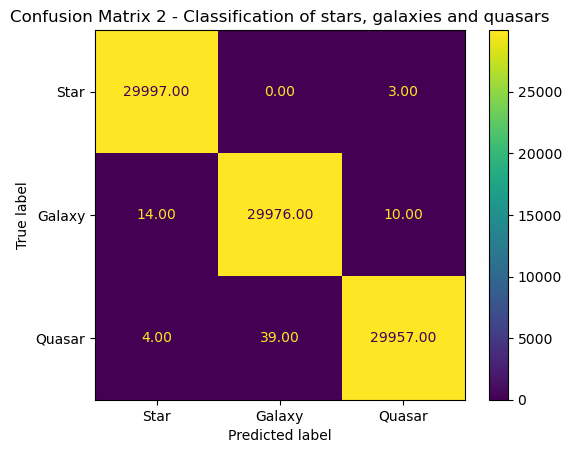

In [92]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

class_names = ['Star', 'Galaxy', 'Quasar']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.viridis, values_format=".2f")

plt.title("Confusion Matrix 2 - Classification of stars, galaxies and quasars")
plt.show()

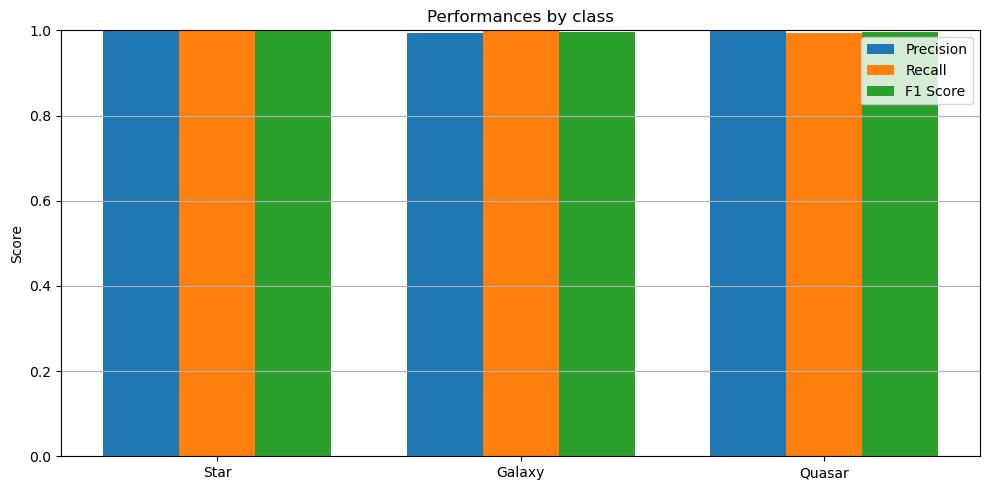

      Class  Precision    Recall  F1 Score
0      Star   0.997536  0.998700  0.998118
1    Galaxy   0.994586  0.998167  0.996373
2    Quasar   0.998091  0.993333  0.995706
3  Accuracy   0.996733  0.996733  0.996733


In [76]:
def plot_metrics(y_test, y_pred_test, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test)

    x = range(len(class_names))

    plt.figure(figsize=(10, 5))
    plt.bar(x, precision, width=0.25, label='Precision', align='center')
    plt.bar([i + 0.25 for i in x], recall, width=0.25, label='Recall', align='center')
    plt.bar([i + 0.5 for i in x], f1, width=0.25, label='F1 Score', align='center')
    plt.xticks([i + 0.25 for i in x], class_names)
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Performances by class')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_metrics(y_test, y_pred_test, class_names=["Star", "Galaxy", "Quasar"])

def display_metrics_table(y_test, y_pred_test, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test)
    accuracy = accuracy_score(y_test, y_pred_test)

    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    accuracy_row = pd.DataFrame({
        'Class': ['Accuracy'],
        'Precision': [accuracy],
        'Recall': [accuracy],
        'F1 Score': [accuracy]
    })

    metrics_df = pd.concat([metrics_df, accuracy_row], ignore_index=True)
    print(metrics_df)

display_metrics_table(y_test, y_pred_test, class_names=["Star", "Galaxy", "Quasar"])


### Importance of features

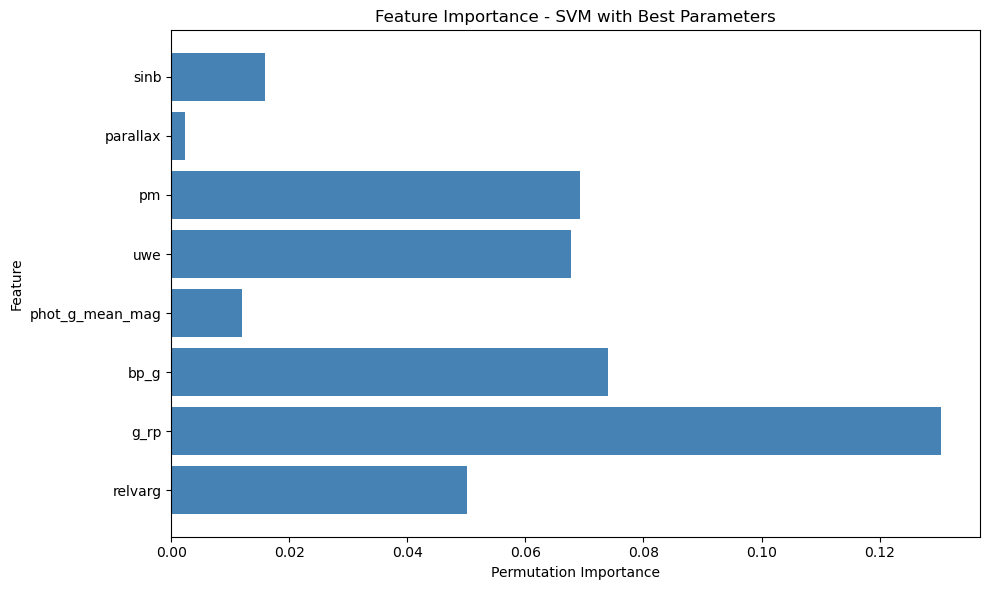

In [79]:
# Manually define the feature names (as used earlier in your pipeline)

# Compute permutation importances
result = permutation_importance(search.best_estimator_, X_train_sub, y_train_sub, n_repeats=10, random_state=42, n_jobs=-1)

# Extract importances
importances = result.importances_mean

# Plot with horizontal bars
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='steelblue')
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - SVM with Best Parameters")
plt.gca().invert_yaxis()  # Optional: most important feature at the top
plt.tight_layout()
plt.show()